*Note: 10x Genomics does not provide support for community-developed tools and makes no guarantees regarding their function or performance. Please contact tool developers with any questions.*

## How to Use This Google Colab

1. **Set the Runtime Type**: From the top menu, click **Runtime** → **Change runtime type**. Ensure the **Runtime type** is set to **R**. For optimal performance, we recommend selecting **v2-8 TPU** for this tutorial.

2. **Connect to the Runtime**: Click the **Connect** button in the top-right corner to establish a connection. Once connected, you are ready to begin the tutorial.

3. **Choose Your Data**: You can run the analysis using the provided dataset or load your own data by following the instructions at the beginning of each section.

# **1. Install packages**

## **1.a. Install Packages from R Repositories**

**Note:** This step may take a significant amount of time. This step is recommended if you plan to run these analyses on your own computing system, as it ensures your packages are up-to-date. For in-person events, this section is not advised due to time constraints.

In [ ]:
system("sudo apt-get install libmagick++-dev")
install.packages("Seurat")
install.packages("harmony")
remotes::install_github('satijalab/seurat-wrappers')
devtools::install_github('immunogenomics/presto')
remotes::install_github("bnprks/BPCells/r")
install.packages("hdf5r")

## **1.b. Install Pre-Installed Packages from AWS S3 Bucket (R)**

**Note:** This approach is ideal for in-person events as it significantly reduces installation time. However, please note that the packages provided may not be the most up-to-date versions.

In [ ]:
system("wget https://cf.10xgenomics.com/supp/xenium/analysis-workshop/R_library_v4-5.tar.gz")

# move all pre-installed R packages to default R folder path
system("tar -xzvf /content/R_library_v4-5.tar.gz")
system(paste0("mv /content/R_library_v4-5/* ", .libPaths()[1]))

# **2. Download practice datasets**

In this notebook, we analyze two Visium HD samples derived from the same clinical specimen: one representing colon cancer tissue and the other representing normal adjacent tissue. These datasets, Sample P5 CRC and Sample P5 NAT, are publicly available and can be accessed [here](https://www.10xgenomics.com/products/visium-hd-spatial-gene-expression/dataset-human-crc).


Visium HD sample can be very large. The two samples we are working with have in total ~1 million 8um bins. If analyzing full datasets, the memory required to store the expression matrices can present a challenge. Here we use Seurat sketch to subsample bins from each large Visium HD sample while preserving rare populations (see detailed Seurat sketch tutorial for multi-sample integration [here](https://satijalab.org/seurat/articles/parsebio_sketch_integration)). Then we will remove batch effects using Harmony, which is one of the top performing tools for bacth correction ([Tran, et al., 2020](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1850-9)).

To perform integration, we require the `filtered_feature_bc_matrix.h5` file from the Space Ranger outputs. Specifically, for integrating 8 µm bins across multiple samples, the file can be found under `binned_outputs/square_008um/filtered_feature_bc_matrix.h5` for each sample. Additionally, we need the corresponding `binned_outputs/square_008um/filtered_feature_bc_matrix/features.tsv.gz` file, which will be used for gene name conversion, as explained later.

In the code block below, we download the 8 µm binned data files (`filtered_feature_bc_matrix.h5` and `features.tsv.gz`) for each Visium HD sample.


In [ ]:
system("wget https://cf.10xgenomics.com/supp/spatial-exp/analysis-workshop/visium_hd_multisample.tar.gz")
system("tar -xzvf /content/visium_hd_multisample.tar.gz")

# **3. Create on-disk matrices for both Visium HD samples**

In [ ]:
library(Seurat)
library(ggplot2)
library(BPCells)
library(SeuratWrappers)
# this is needed for large datasets
options(future.globals.maxSize = 1e10)

In [ ]:
# load colon cancer data
colon_cancer <- open_matrix_10x_hdf5(
  path = "/content/visium_hd_multisample/Colon_Cancer_P5_008um/filtered_feature_bc_matrix.h5",
  feature_type = "Gene Expression"
)

# Write the colon cancer matrix on disk
write_matrix_dir(mat = colon_cancer,
                 dir = "/content/colon_cancer_matrix",
                 overwrite = TRUE)

In [ ]:
# load colon normal data
colon_normal <- open_matrix_10x_hdf5(
  path = "/content/visium_hd_multisample/Colon_Normal_P5_008um/filtered_feature_bc_matrix.h5",
  feature_type = "Gene Expression"
)

# Write the colon normal matrix on disk
write_matrix_dir(mat = colon_normal,
                 dir = "/content/colon_normal_matrix",
                 overwrite = TRUE)

Now we have matrix on-disk. When something is "on-disk," it means that the data, file, or object is stored on a physical storage device within a computer. This storage is permanent, meaning the data persists even when the computer is turned off, unlike temporary storage like RAM.

Now that we have the matrix on-disk, we will load it into our environment.


In [ ]:
# load on-disk matrix of colon cancer data
colon_cancer_count <- open_matrix_dir(dir = "/content/colon_cancer_matrix")

When combining data from multiple samples, it is good practice to make bin IDs unique across all integrated samples. Here, we add suffixes to bin IDs. For example, we add a ".cancer" suffix to each bin ID in colon cancer data and a ".normal" suffix to each bin ID in colon normal data.

In [ ]:
# add ".cancer" suffix to barcode IDs
colnames(colon_cancer_count) <- paste(colnames(colon_cancer_count),"cancer",sep = ".")

By default, the output matrix uses Ensembl IDs, which are less intuitive than gene names. To enhance data interpretability, we will convert these Ensembl IDs to their corresponding gene names. The `features.tsv.gz` file, provided with each Visium bin output, contains the necessary mapping for this conversion.

In [ ]:
# convert Ensembl IDs to gene names
features <- read.table("/content/visium_hd_multisample/Colon_Cancer_P5_008um/features.tsv.gz",
                       sep="\t", header=FALSE)
features <- features[(features$V3 == "Gene Expression"),]
features <- features[match(rownames(colon_cancer_count), features$V1),]
rownames(colon_cancer_count) <- features$V2

In [ ]:
# we do the same thing for colon normal data

# load on-disk colon normal matrix
colon_normal_count <- open_matrix_dir(dir = "/content/colon_normal_matrix")

# add ".normal" suffix to barcode IDs
colnames(colon_normal_count) <- paste(colnames(colon_normal_count),"normal",sep = ".")

# convert Ensembl IDs to gene names
features <- read.table("/content/visium_hd_multisample/Colon_Normal_P5_008um/features.tsv.gz",
                       sep="\t", header=FALSE)
features <- features[(features$V3 == "Gene Expression"),]
features <- features[match(rownames(colon_normal_count), features$V1),]
rownames(colon_normal_count) <- features$V2

# **4. Create a Seurat object (having both Visium HD samples) with on-disk matrix**

In [ ]:
# create a list having both colon cancer and normal on-disk matrices
countlist <- list(colon_cancer_count, colon_normal_count)
names(countlist) <- c("cancer","normal")

In [ ]:
# create a Seurat object for both colon cancer and normal data
merge.obj <- CreateSeuratObject(countlist)

Now bins from both colon cancer and normal data are in one Seurat object. We will add one column, `sample`, to the Seurat object meta.data so that we can distinguish the sample origin.

In [ ]:
samples <- sapply(strsplit(colnames(merge.obj),"\\."),function(X){return(X[2])})
merge.obj$samples <- samples

# **5. "Sketch" subsampled bins and load these bins in memory**

The initial step involves Quality Control (QC) to remove bins with low Unique Molecular Identifier (UMI) counts. We begin by plotting the distribution of UMI counts per 8µm bin in a histogram. This visualization aids in determining a lower cutoff for transcript counts, specifically targeting the removal of bins with low UMIs. The precise determination of this lower cutoff can be subjective, as no universally applicable standard exists. The objective is to remove low-quality bins and those likely not associated with tissue. Identifying the optimal lower cutoff often involves empirical testing and visual assessment of the bins overlaid on your tissue image.

In [ ]:
# genrate histogram of UMI counts and show line at UMI count = 40 to demonstrate where our threshold will be
hist(merge.obj$nCount_RNA, xlim=c(0,200), breaks = 5000)
abline(v = 40)

For this analysis, we have selected a lower UMI cutoff of 40 and will use the 98th percentile as the upper limit cutoff. Please note that these specific cutoffs are for demonstration purposes only. We recommend visually inspecting the removed bins to confirm they are indeed of lower quality.

In [ ]:
## QC
## filtering bin based on detected UMIs per bin
## Upper limit cutoff - 98th percentile
## Lower limit cutoff - 40
# runtime: 23s
thres <- quantile(merge.obj$nCount_RNA, c(0.98))
merge.obj <- subset(merge.obj, subset = nCount_RNA >= 40 & nCount_RNA <= thres[1])

Next, we will normalize our data. We will use median transcript count as the scale factor to normalize based on library size.

In [ ]:
## Normalization
## library size based normalization, scale factor - median transcript count
## runtime: 28s
merge.obj <- NormalizeData(merge.obj,scale.factor=median(merge.obj$nCount_RNA), verbose = FALSE)

Next, we will find the top 2,000 variable genes to be used for principal component analysis (PCA) later on.

In [ ]:
## Find top 2k variable genes
# runtime: 16s
merge.obj <- FindVariableFeatures(merge.obj, verbose = FALSE)

In the next section, we will subsample (sketch) bins from all bins so that our data are more manageable. We will downsample both of our samples to 25,000 bins. This number was selected for demonstration purposes. You will need to consider how many bins you have for each sample and how many would still be representative of the entire dataset when deciding on the downsample number.

This step takes 3-4 mins.

**Note for In-Person Events**: This step will be skipped. We will directly load the pre-generated results from this step.

In [ ]:
############################ SKIP this step for in-person events ###################################
## you will need to change ncells (downsample number) based on bin number you have per sample
## ncells = 25000 (meaning selecting 25k bins for each of two data);
## if we set ncells = c(25000, 35000), it will downsample 25k for colon cancer data and 35k for normal data
## runtime: 3mins
merge.obj <- SketchData(merge.obj, ncells = 25000,
                        method = "LeverageScore",
                        sketched.assay = "sketch",
                        features = VariableFeatures(merge.obj))

In [ ]:
##################### load pre-generated result during in-person events ###########################
merge.obj <- readRDS("/content/visium_hd_multisample/backup/HD_integration_after_SketchData.rds")

# **6. Conventional data processing**

Now that we have a representative 50k bins (located in the `sketch` assay of the Seurat object) downsampled from all bins (in the `RNA` assay of the Seurat object), analysis will proceed much faster. In the next code block, we will perform conventional data processing, which includes: find variable genes, data scaling, and Principal Component Analysis (PCA).

In [ ]:
## runtime: 1min
DefaultAssay(merge.obj) <- "sketch"
merge.obj <- FindVariableFeatures(merge.obj, verbose = FALSE)
merge.obj <- ScaleData(merge.obj, verbose = FALSE)
merge.obj <- RunPCA(merge.obj, verbose = FALSE)

# **7. Batch correction by Harmony**

Before doing batch correction, we can check if there are significant batch effects between these two samples. First, we will project bins in 2D UAMP space without any batch correction and visualize bins by their sample origins. If most of cell types are very well separated between samples in UMAP space, it could indicate batch effects. In this case, we actually do not observe significant batch effects in the UMAP space. However, we want to walk through running Harmony for demonstration purposes. For more information about how to identify batch effects, see our analysis guide [here](https://https://www.10xgenomics.com/analysis-guides/introduction-batch-effect-correction).

In [ ]:
# directly run UMAP on uncorrected PCA results (aka without batch correction)
# runtime: 1min
merge.obj <- RunUMAP(merge.obj, dims = 1:30, return.model = TRUE, verbose = FALSE)

In [ ]:
# plot UMAP and color cells by sample origins
DimPlot(merge.obj, group.by = "samples")

For this demonstration, we will proceed with batch correction using Harmony.

Harmony corrects the Principal Component Analysis (PCA) space, addressing variations introduced by batch effects. Upon correcting batch effects, Harmony generates new, reduced-dimension results, referred to as the `harmony` space.

In [ ]:
## runtime: 1mins
merge.obj <- IntegrateLayers(merge.obj, method = HarmonyIntegration,
                             orig = "pca", new.reduction = "harmony",
                             dims = 1:30)

In [ ]:
merge.obj

Based on batch corrected space - harmony, we can do UMAP projection and clustering.

In [ ]:
# UMAP analysis based on batch corrected harmony space
# runtime: 1min
merge.obj <- RunUMAP(merge.obj, reduction = "harmony", dims = 1:30,
                    return.model = TRUE, verbose = FALSE)

In [ ]:
# clustering based on batch corrected harmony space
# runtime: 55s
merge.obj <- FindNeighbors(merge.obj, reduction = "harmony", dims = 1:30, verbose = FALSE)
merge.obj <- FindClusters(merge.obj, resolution = .5, verbose = FALSE)

We can now plot the batch-corrected UMAP, labeling cells by their sample origins and visualizing the clustering results. Minimal discernible differences in the data are observed, consistent with the absence of significant batch effects prior to Harmony correction.

In [ ]:
# plot UMAP after batch correction
DimPlot(merge.obj, group.by = "samples")
DimPlot(merge.obj)

# **8. Project results from "sketch" 50k bins to all bins**

The following two steps project results from "sketch" bins to all bins. As these steps can be time-consuming, pre-generated results have been prepared.

**Note for In-Person Events**: These two steps will be skipped. We will directly load the pre-generated results.

In [ ]:
############### SKIP these steps for in-person events ###################

# proeject harmony results from 50k bins (sketch) to all bins (RNA)
# after projection, harmony space for all cells is generated as harmony.full
# runtime: 46s
merge.obj <- ProjectIntegration(object = merge.obj,
                                sketched.assay = "sketch", assay = "RNA",
                                reduction = "harmony")



# project batch corrected clustering results from 50k bins to all bins ("cluster_full")
# project batch corrected UMAP results from 50k bins to all bins ("full.umap")
# runtime: 8mins
merge.obj <- ProjectData(
  object = merge.obj,
  assay = "RNA",
  full.reduction = "harmony.full",
  sketched.assay = "sketch",
  sketched.reduction = "harmony.full",
  umap.model = "umap",
  dims = 1:30,
  refdata = list(cluster_full = "seurat_clusters")
)

In [ ]:
##################### load pre-generated result for in-person events ###########################
merge.obj <- readRDS("/content/visium_hd_multisample/backup/HD_integration_after_ProjectData.rds")

Following the projection of results from 50k bins to all bins, we will visualize the batch-corrected UMAP results for all bins.

In [ ]:
merge.obj

In [ ]:
DimPlot(merge.obj, reduction = "full.umap", group.by = "cluster_full",label = TRUE)

In [ ]:
DimPlot(merge.obj, reduction = "full.umap", group.by = "samples")

# **9. Export all bin clustering results in csv and import to Loupe Browser**

Following batch correction, the clustering results can be exported as separate CSV files for both colon cancer and normal adjacent data. Each sample's clustering results (generated by integrative analysis) can then be imported into its corresponding Loupe Browser file.

In [ ]:
clusters_all <- FetchData(merge.obj, vars = c("cluster_full","samples"))

# since we added suffix in cell IDs in Section 3, here we need to remove suffix, back to original IDs
clusters_all$cell_id <- sapply(strsplit(rownames(clusters_all),"\\."),function(X){return(X[1])})
head(clusters_all)

,cluster_full,samples,cell_id
,<chr>,<chr>,<chr>
s_008um_00602_00290-1.cancer,0,cancer,s_008um_00602_00290-1
s_008um_00789_00234-1.cancer,1,cancer,s_008um_00789_00234-1
s_008um_00728_00006-1.cancer,1,cancer,s_008um_00728_00006-1
s_008um_00526_00291-1.cancer,4,cancer,s_008um_00526_00291-1
s_008um_00681_00396-1.cancer,0,cancer,s_008um_00681_00396-1
s_008um_00078_00444-1.cancer,4,cancer,s_008um_00078_00444-1


In [ ]:
# get clustering results for cancer data
clusters_all_cancer <- clusters_all[(clusters_all$samples == "cancer"),c("cell_id","cluster_full")]
colnames(clusters_all_cancer) <- c("Barcode","Cluster")
write.table(clusters_all_cancer,"integrated_clusters_for_cancer.csv",
            sep=",", col.names=TRUE, row.names=FALSE, quote=FALSE)

In [ ]:
# get clustering results for normal data
clusters_all_normal <- clusters_all[(clusters_all$samples == "normal"),c("cell_id","cluster_full")]
colnames(clusters_all_normal) <- c("Barcode","Cluster")
write.table(clusters_all_normal,"integrated_clusters_for_normal.csv",
            sep=",", col.names=TRUE, row.names=FALSE, quote=FALSE)

Clustering results can now be uploaded to the Loupe Browser file.

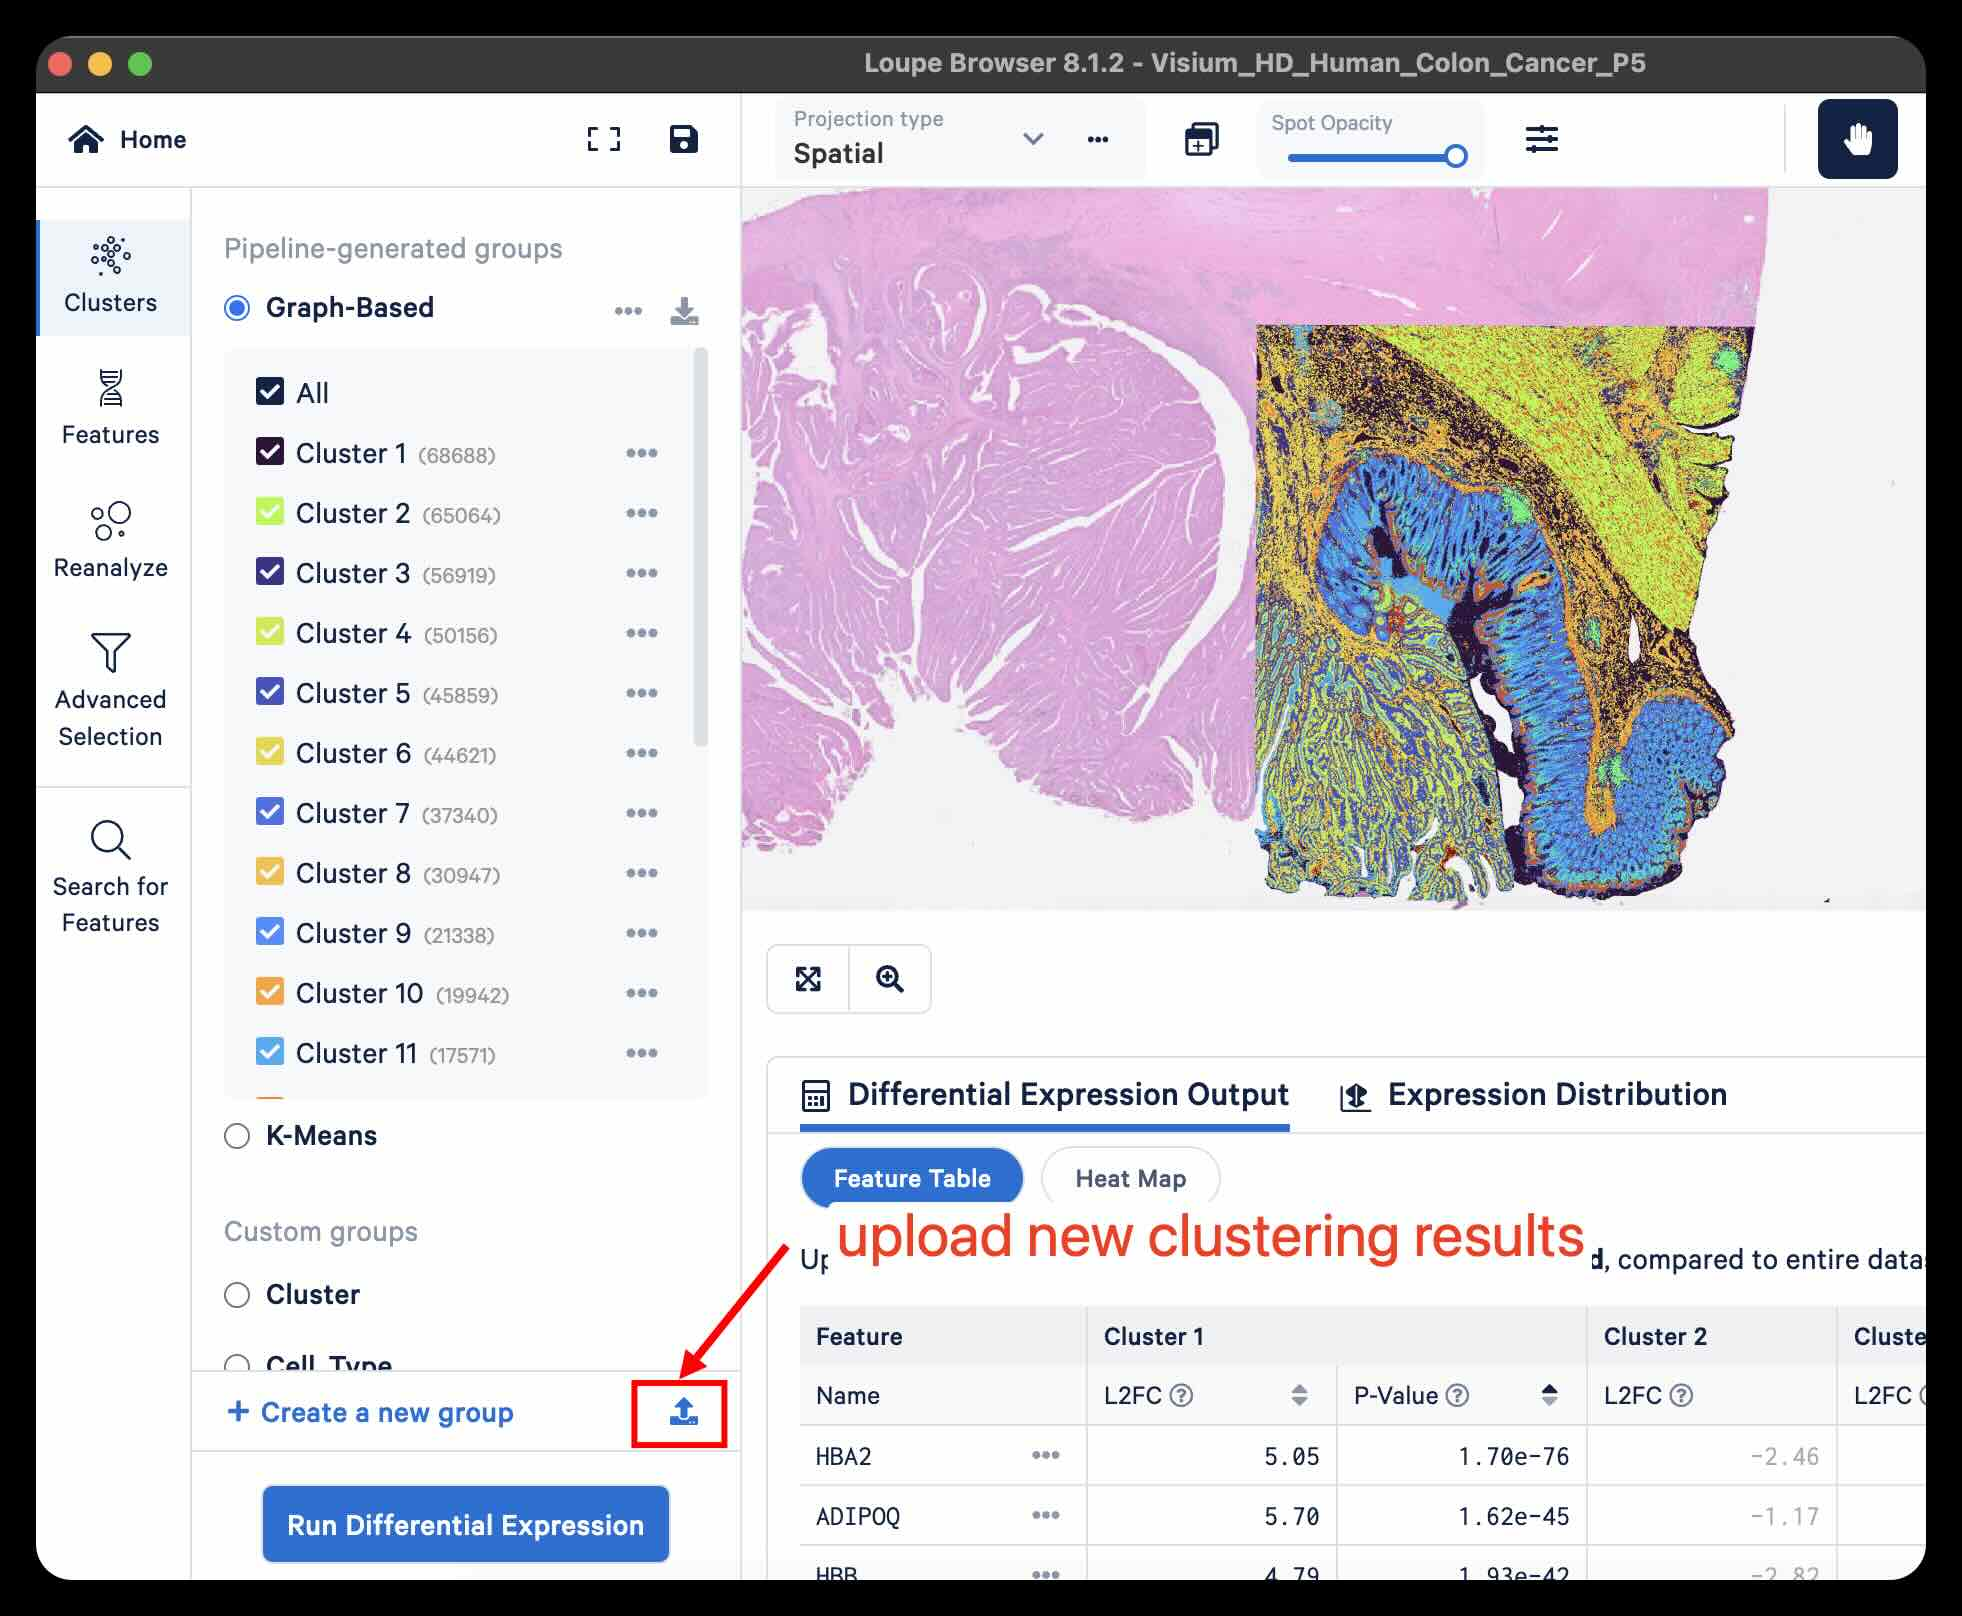

# **10. Find cluster marker genes for cell annotation**

We can compute marker genes for each cluster to facilitate cluster annotation. For this analysis, we will again use the `sketch` assay within the Seurat object.

In [ ]:
merge.obj

In [ ]:
DefaultAssay(merge.obj) <- "sketch"

# join cancer and normal matrices in sketch (50k cells)
merge.obj[["sketch"]] <- JoinLayers(merge.obj[["sketch"]])

# calculate marker genes for each cluster
all.markers <- FindAllMarkers(merge.obj, only.pos = TRUE)

In [ ]:
# save marker gene results in csv
write.table(all.markers,"markers_for_all_clusters_in_sketch.csv", sep=",", col.names = TRUE,
            row.names=FALSE, quote=FALSE)

Here we are sharing one possible way to annotate each cluster.

Step 1. Get marker genes in each cluster.

Step 2. Find cell type that is highly associated with the provided marker genes via third-party tools, such as [Enrichr](https://maayanlab.cloud/Enrichr/).

Step 3. Check cluster in HE image and confirm cell type.

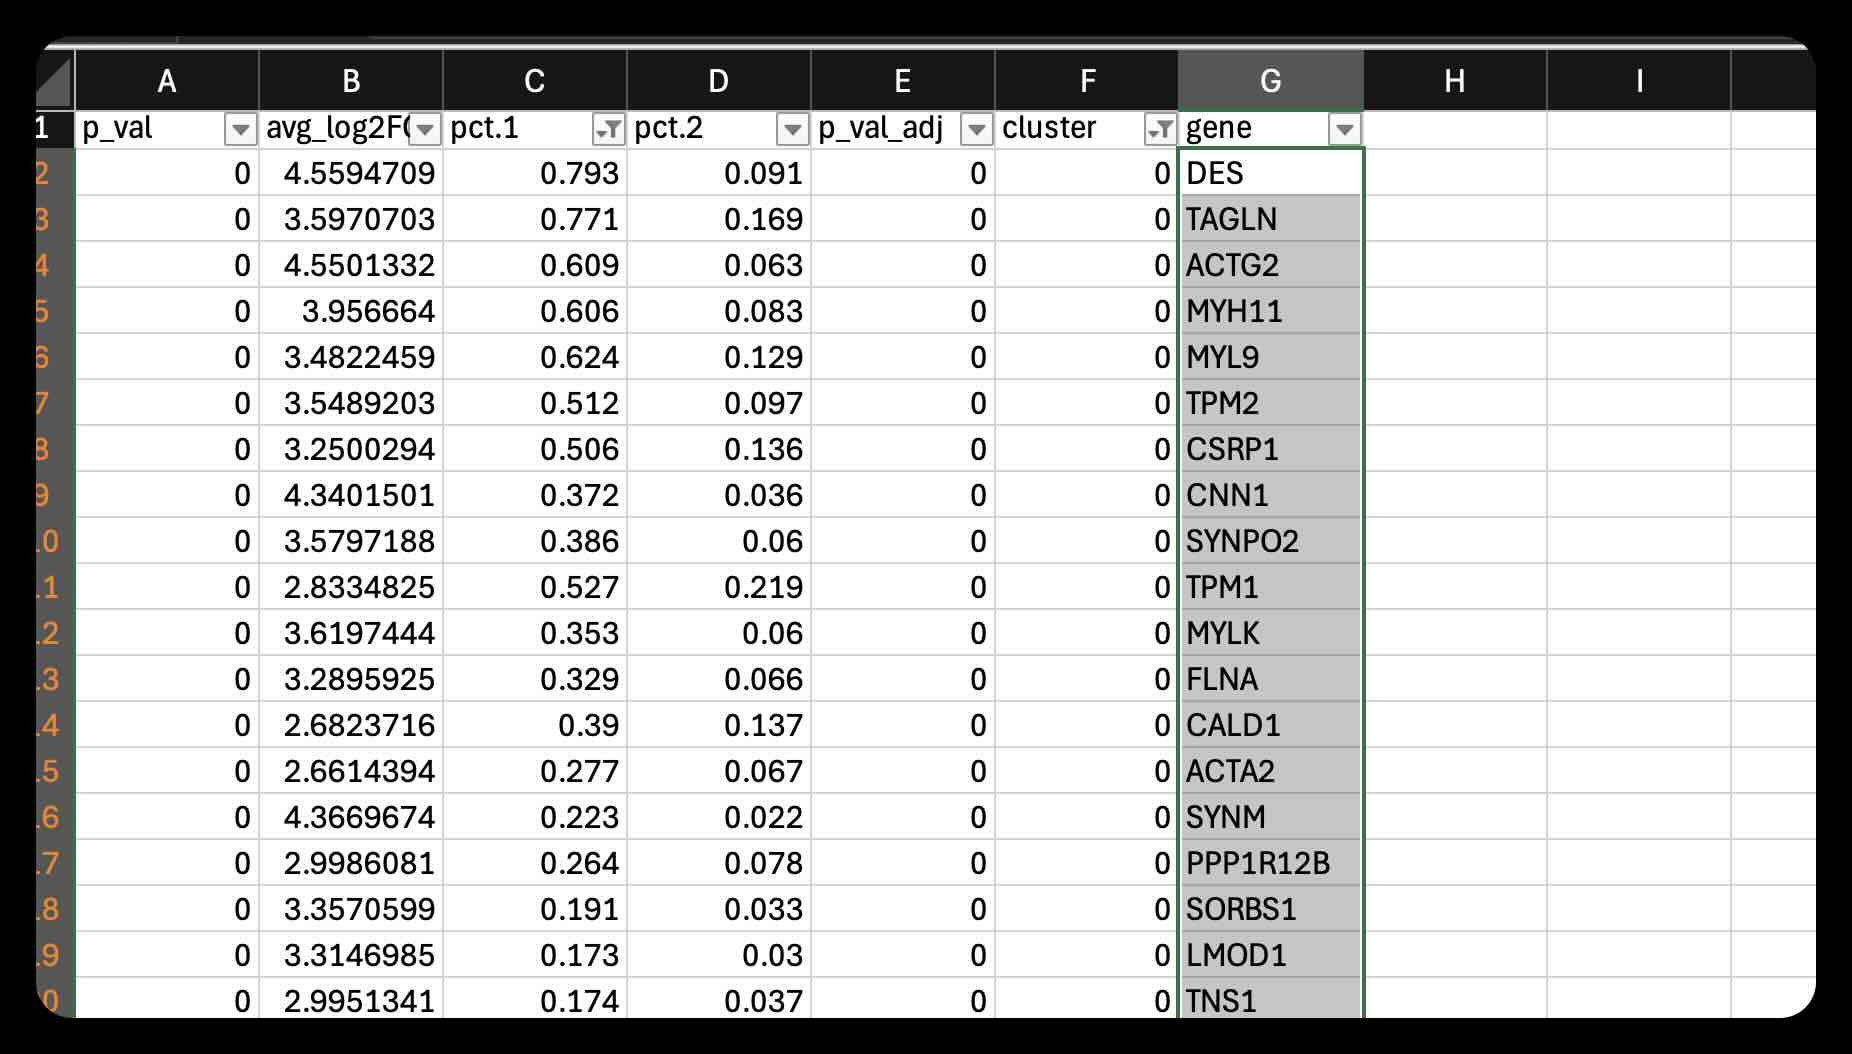

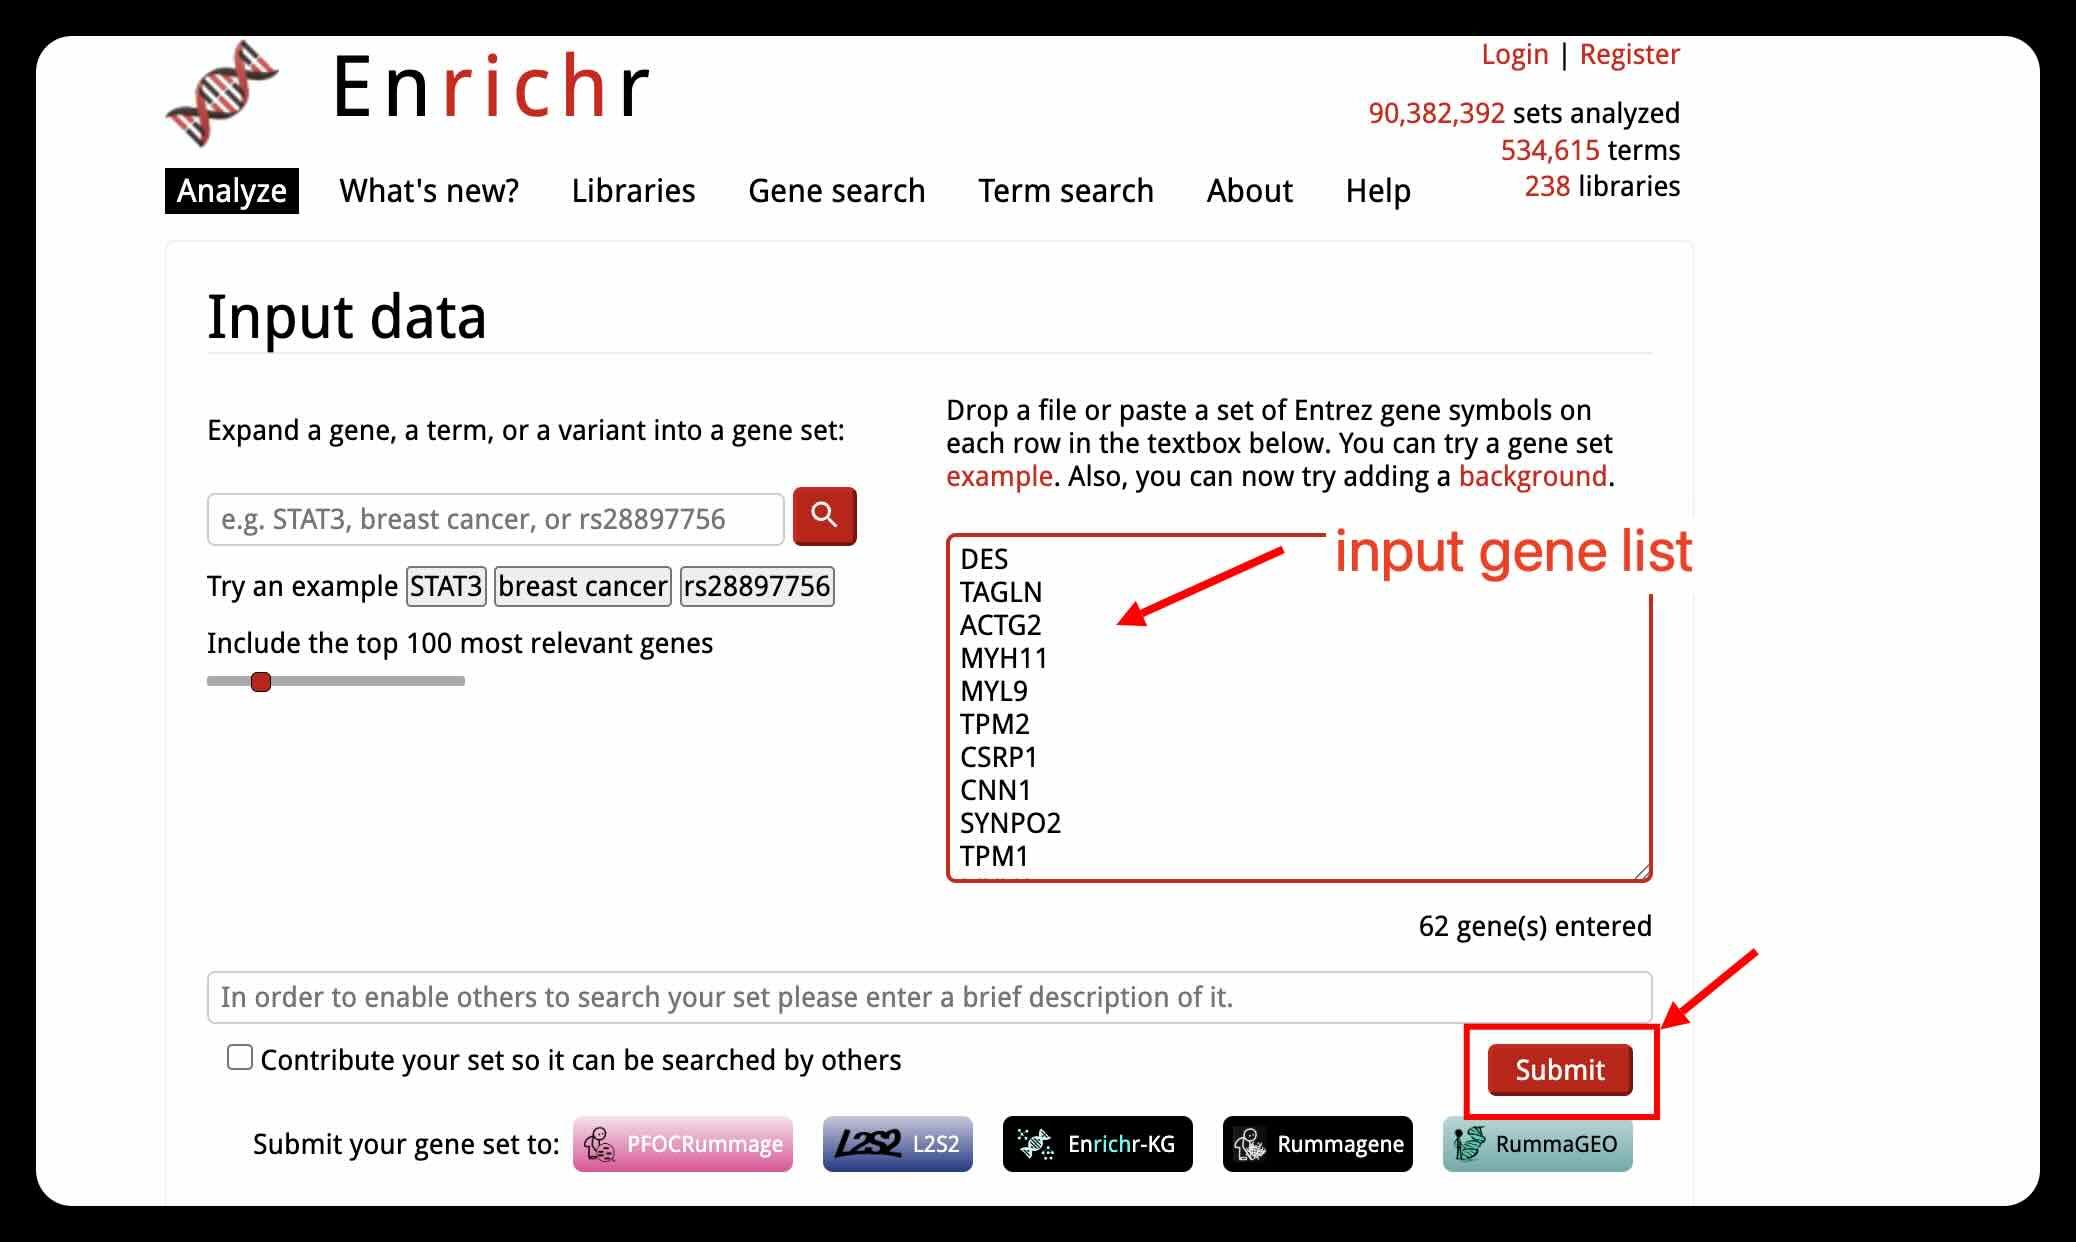

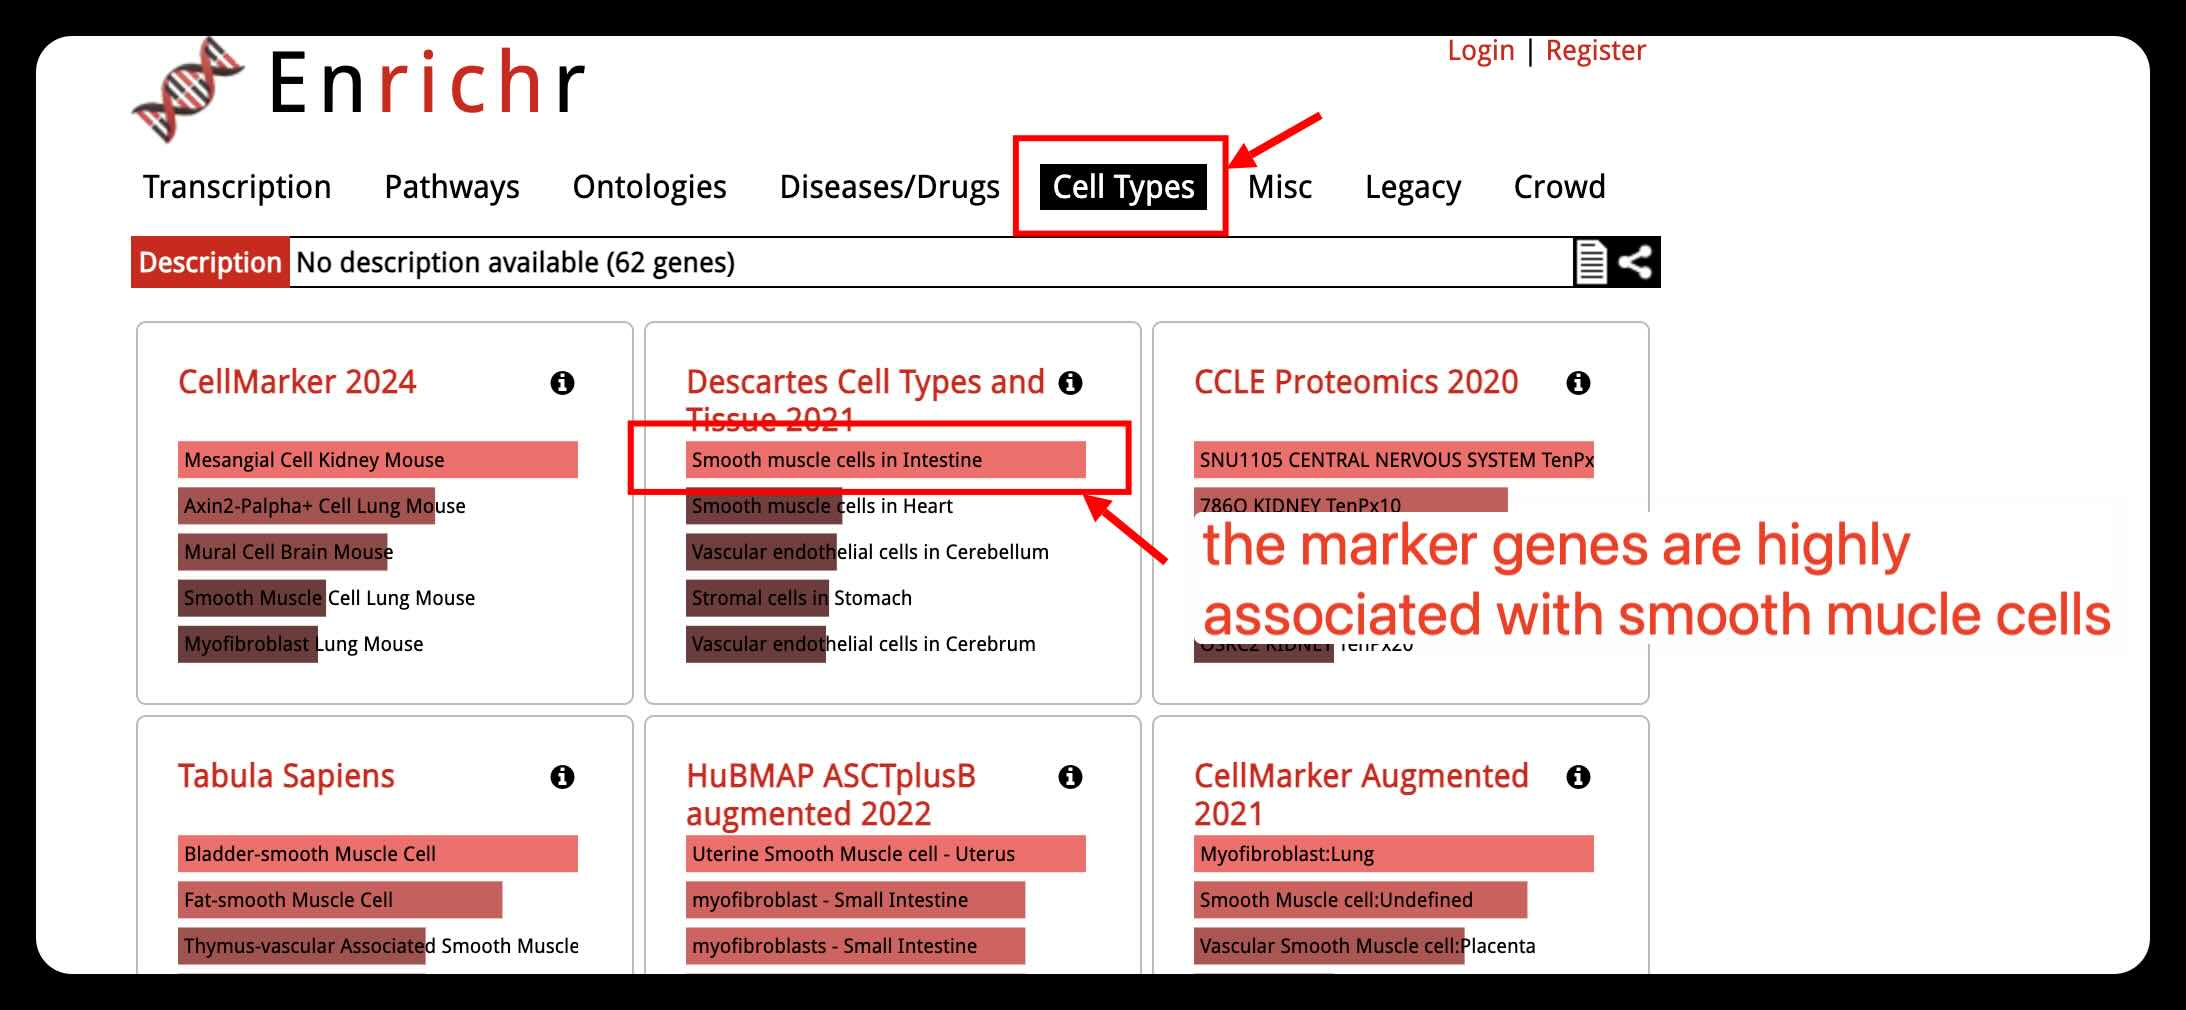

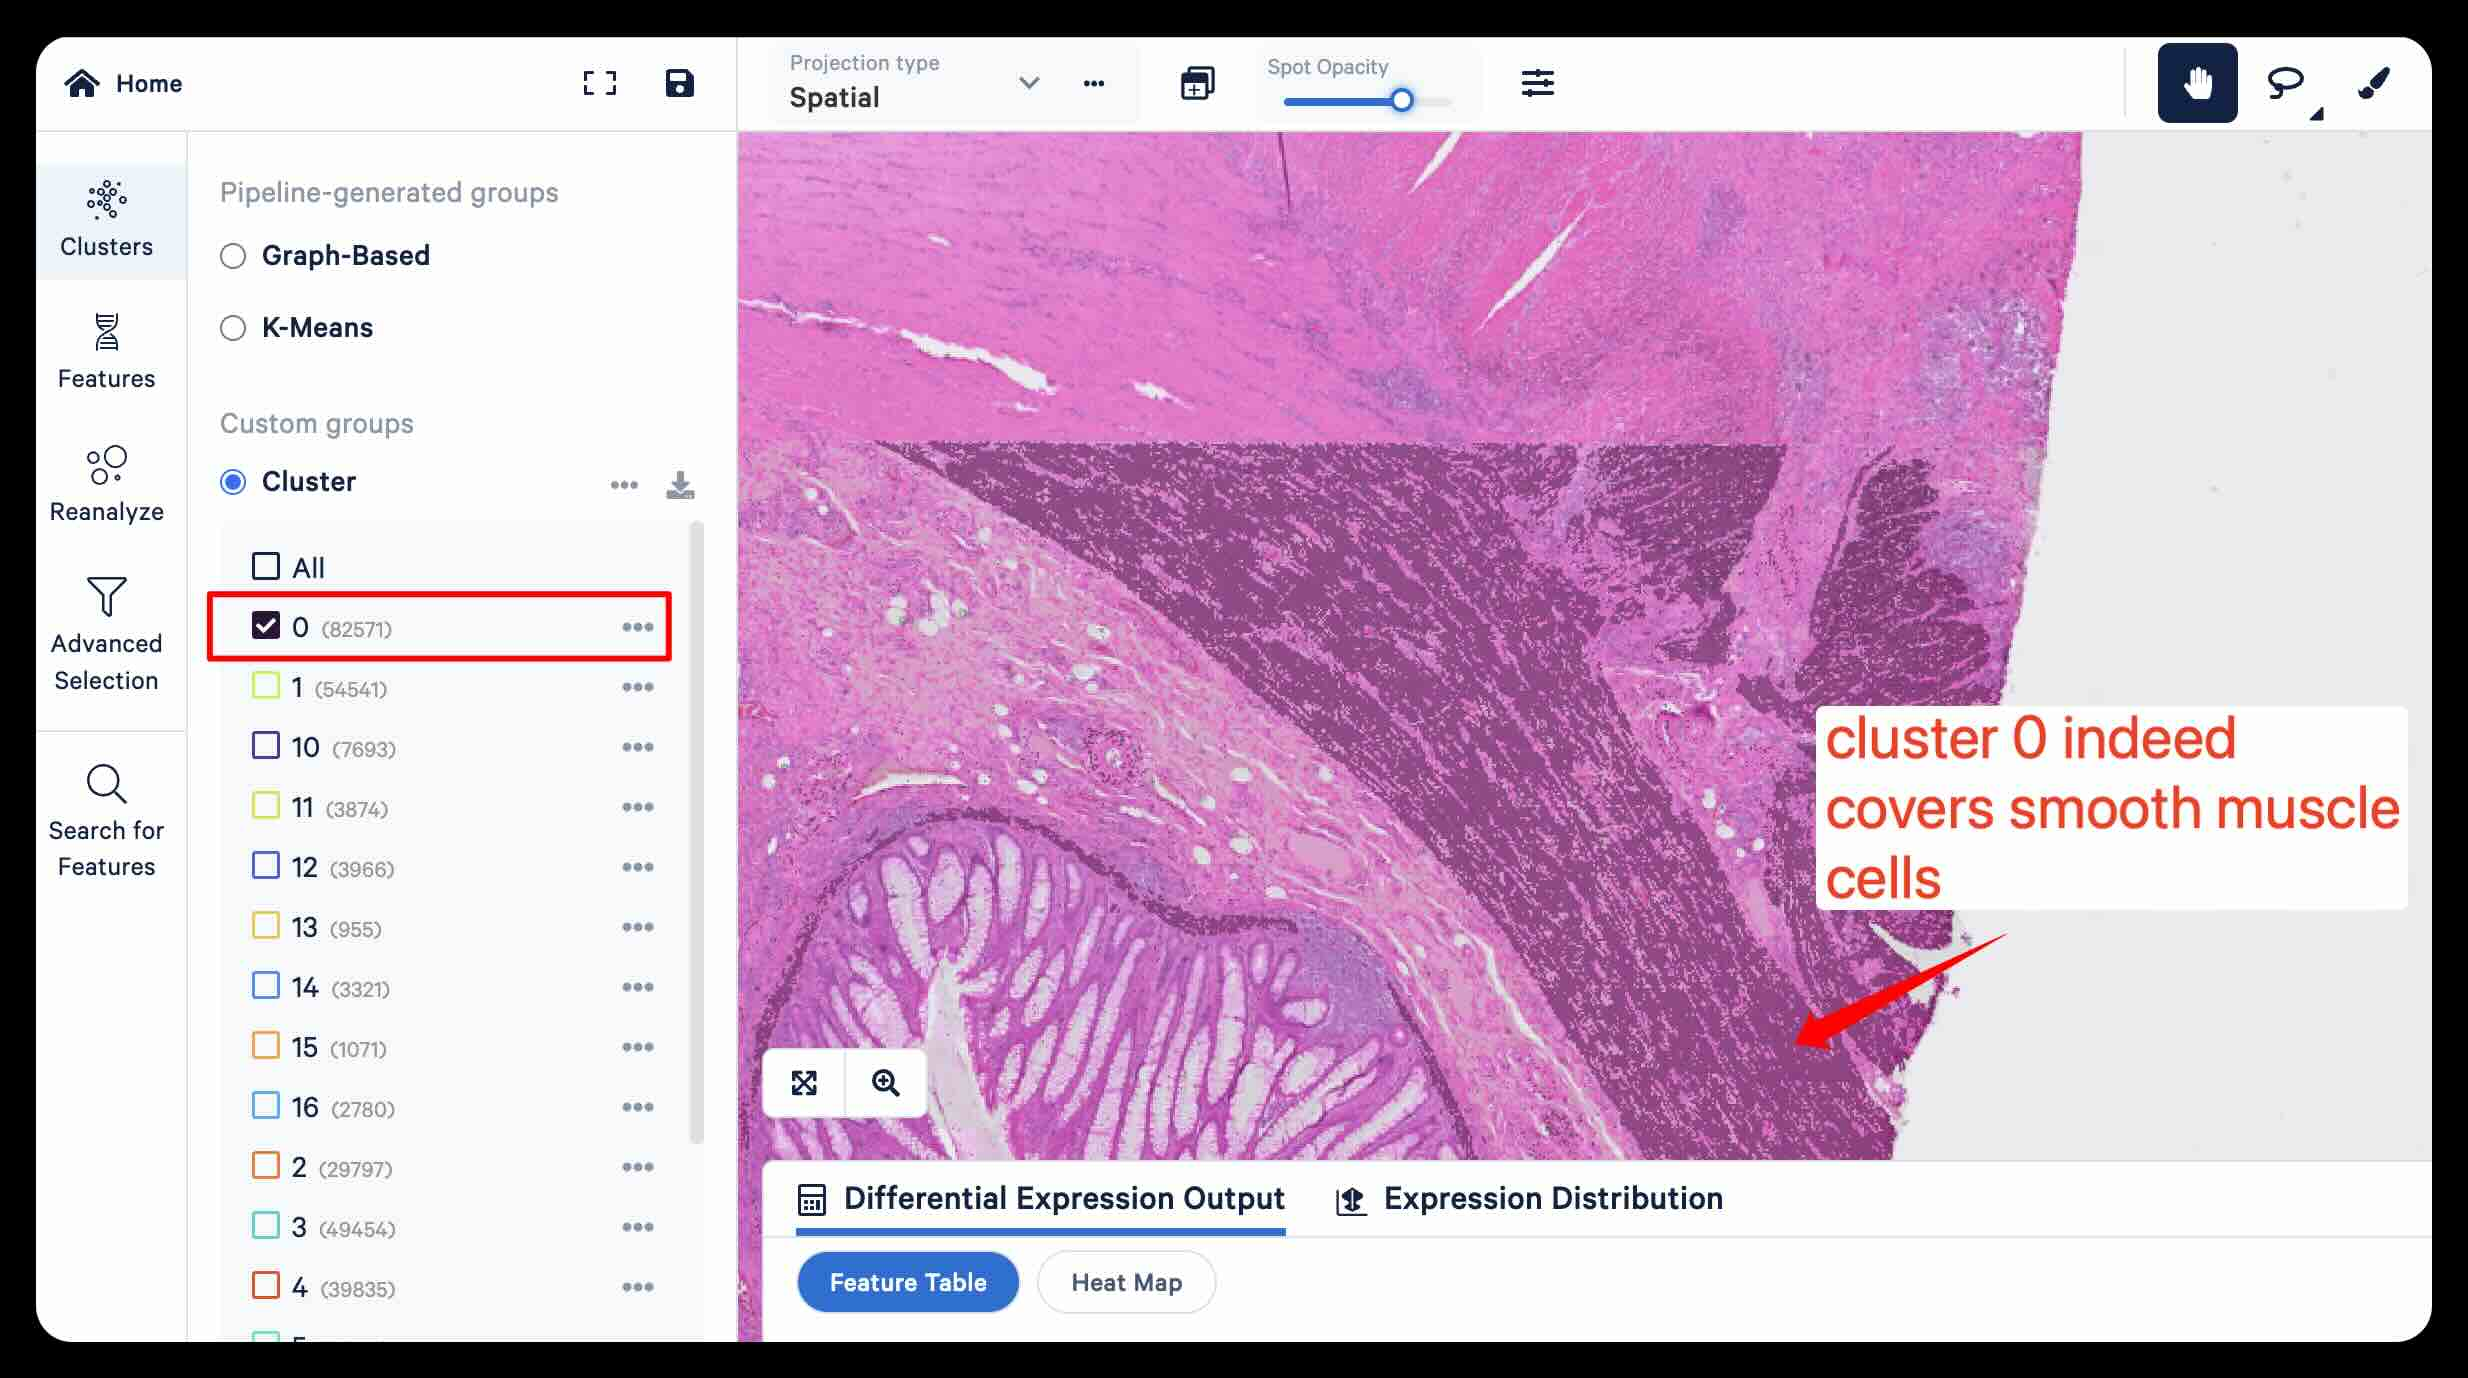

In [ ]:
clusters_all$cell_type <- NA
clusters_all[(clusters_all$cluster_full == 0), "cell_type"] <- "smooth muscle cells"
clusters_all[(clusters_all$cluster_full == 1), "cell_type"] <- "filbroblasts/stromal"
clusters_all[(clusters_all$cluster_full == 2), "cell_type"] <- "endothelial"
clusters_all[(clusters_all$cluster_full == 3), "cell_type"] <- "globlet cells"
clusters_all[(clusters_all$cluster_full == 4), "cell_type"] <- "globlet cells"
clusters_all[(clusters_all$cluster_full == 5), "cell_type"] <- "plasma B"
clusters_all[(clusters_all$cluster_full == 6), "cell_type"] <- "macrophages"
clusters_all[(clusters_all$cluster_full == 7), "cell_type"] <- "B cells"
clusters_all[(clusters_all$cluster_full == 8), "cell_type"] <- "globlet cells"
clusters_all[(clusters_all$cluster_full == 9), "cell_type"] <- "tumor"
clusters_all[(clusters_all$cluster_full == 10), "cell_type"] <- "filbroblasts/stromal"
clusters_all[(clusters_all$cluster_full == 11), "cell_type"] <- "nerve"
clusters_all[(clusters_all$cluster_full == 12), "cell_type"] <- "mast cells"
clusters_all[(clusters_all$cluster_full == 13), "cell_type"] <- "ENS neuron"
clusters_all[(clusters_all$cluster_full == 14), "cell_type"] <- "neutrophils"
clusters_all[(clusters_all$cluster_full == 15), "cell_type"] <- "enteroendocrine"
clusters_all[(clusters_all$cluster_full == 16), "cell_type"] <- "endothelial"

In [ ]:
head(clusters_all)

Export cell annotation results to a CSV file and import them into the Loupe Browser file.

In [ ]:
clusters_all_cancer <- clusters_all[(clusters_all$samples == "cancer"),c("cell_id","cell_type")]
colnames(clusters_all_cancer) <- c("Barcode","Cell_Type")
write.table(clusters_all_cancer,"cell_annotation_for_cancer.csv",
            sep=",", col.names=TRUE, row.names=FALSE, quote=FALSE)

In [ ]:
clusters_all_normal <- clusters_all[(clusters_all$samples == "normal"),c("cell_id","cell_type")]
colnames(clusters_all_normal) <- c("Barcode","Cell_Type")
write.table(clusters_all_normal,"cell_annotation_for_normal.csv",
            sep=",", col.names=TRUE, row.names=FALSE, quote=FALSE)

Cell annotation results can be stored within the Seurat object.

In [ ]:
clusters_all <- clusters_all[colnames(merge.obj),]
merge.obj$cell_type <- clusters_all$cell_type

Plot cell annotation results using UMAP.

In [ ]:
DimPlot(merge.obj, reduction = "full.umap", group.by = "cell_type", label = TRUE)

# **11. Save Seurat object**

The Seurat object (including the sketch assay) can be saved locally as an RDS file using `saveRDS`. Note that this Seurat object links to on-disk data residing in the `colon_cancer_matrix` and `colon_normal_matrix` folders. Therefore, the complete saved dataset comprises the RDS file and all associated on-disk data folders.

In [ ]:
saveRDS(merge.obj,"integrated_HD_Seurat_sketch.rds")

For this demonstration, the `integrated_HD_Seurat_sketch.rds` file must be retained alongside the `colon_cancer_matrix/` and `colon_normal_matrix/` folders as a complete dataset.

For this demonstration, the `integrated_HD_Seurat_sketch.rds` file must be retained alongside the `colon_cancer_matrix/` and `colon_normal_matrix/` folders as a complete dataset.

In [ ]:
# reload integrated Seurat object from rds
merge.obj <- readRDS("./integrated_HD_Seurat_sketch.rds")

# **12. Subset Seurat for fibroblasts**

Looking at both our UMAPs by cell type and by sample, we see that fibroblasts cluster separately by sample even after batch correction. This suggests that fibroblasts are biologically different betewen colon cancer and normal adjaction tissue. To understand the differences, we will hone in on the fibroblasts for further analysis.

In the code block below we subset fibroblasts and compare gene expression in fibroblasts between colon cancer tissue and normal adjacent tissiue. This analysis is more for demonstration and exploration - to compare fibroblasts between two samples. The p-values obtained from this analysis should be interpreted with caution because these tests treat each bin as an independent replicate, which could cause false positives.

**A more robust statistic test for differential expression genes (DEG) between conditions requires biological replicates (at least 3 biological replicates per condition are recommended) and pseudo-bulk DEG analysis approach can be used for this analysis.** See more documentations below:

*   [Differential Gene Expression Analysis in scRNA-seq Data between Conditions with Biological Replicates](https://www.10xgenomics.com/analysis-guides/differential-gene-expression-analysis-in-scrna-seq-data-between-conditions-with-biological-replicates)
*   [Use Seurat for pseudo-bulk DE analysis](https://satijalab.org/seurat/articles/de_vignette#perform-de-analysis-after-pseudobulking)


In [ ]:
# get all barcode IDs for fibroblasts
fibro_cells <- names(merge.obj$cluster_full[(merge.obj$cell_type == "filbroblasts/stromal")])

In [ ]:
# based on fibroblast cell IDs, subset Seurat object
fibro.obj <- subset(merge.obj, cells = fibro_cells)

In [ ]:
fibro.obj

We will now re-analyze the fibroblast cells, performing highly variable gene identification, data scaling, PCA, Harmony correction (on PCA space), and UMAP projection.

With 89k fibroblasts, this subset is sufficiently manageable to perform the analysis directly on all cells within the RNA assay, without requiring further downsampling.

Please note that the following steps can be time-consuming. **For in-person events, these steps will be skipped, and pre-generated results will be loaded directly.**

In [ ]:
################### SKIP these steps for in-person events ###################

DefaultAssay(fibro.obj) <- "RNA"
fibro.obj <- FindVariableFeatures(fibro.obj, verbose = FALSE)
fibro.obj <- ScaleData(fibro.obj, verbose = FALSE)
fibro.obj <- RunPCA(fibro.obj, verbose = FALSE)


# batch correction using harmony
# correcting PCA
# corrected space is named as harmony.full
fibro.obj <- IntegrateLayers(fibro.obj, method = HarmonyIntegration,
                             orig = "pca", new.reduction = "harmony.full",
                             dims = 1:30)


# run UMAP on corrected space (harmony.full)
fibro.obj <- RunUMAP(fibro.obj, reduction = "harmony.full", dims = 1:30,
                     reduction.name = "umap.full",
                     reduction.key = "UMAP_full_", verbose = FALSE)

In [ ]:
##################### load pre-generated result in for in-person events ###########################

fibro.obj <- readRDS("/content/visium_hd_multisample/backup/fibroblast_integrated_HD_seurat.rds")

In [ ]:
options(repr.plot.width=7, repr.plot.height=7)
DimPlot(fibro.obj, reduction = "umap.full", group.by = "samples")

In [ ]:
Idents(object = fibro.obj) <- "samples"
fibro.obj[["RNA"]] <- JoinLayers(fibro.obj[["RNA"]])
fibro.marker <-  FindMarkers(fibro.obj, ident.1 = "cancer", ident.2 = "normal")

Based on the DEG results, many collagen-related genes are significantly upregulated in colon cancer tissue, such as COL1A1, COL3A1, and COL1A2.

In [ ]:
# save DEG results in csv
fibro.marker$gene <- rownames(fibro.marker)
write.table(fibro.marker,"Fibroblasts_DGE.csv", sep=",", col.names = TRUE,
            row.names=FALSE, quote=FALSE)

In [ ]:
options(repr.plot.width=8, repr.plot.height=8)
FeaturePlot(fibro.obj, features = c("COL1A1","COL3A1","COL1A2"),
               reduction = "umap.full",ncol=2)

In [ ]:
options(repr.plot.width=12, repr.plot.height=8)
VlnPlot(fibro.obj, c("COL1A1","COL3A1","COL1A2"), group.by = "samples", pt.size=0)

Spatially visualizing the expression of COL1A1, COL3A1, and COL1A2 in colon cancer and normal adjacent tissues (see Loupe Browser screenshots below, using COL1A1 as an example) reveals their high expression within colon cancer tissue. Interestingly, within colon cancer data alone, fibroblasts located nearer to tumor areas exhibit higher expression of these genes compared to those further away. Previous studies suggest that increased expression of collagen-related genes in colon cancer is associated with poor prognosis ([Jin, et al., 2022](https://www.aging-us.com/article/204261/text), [Zhang, et al., 2018](https://www.spandidos-publications.com/10.3892/mmr.2018.8533), [Wang, et al., 2016](https://www.oncotarget.com/article/6815/text/)).

- Colon cancer tissue

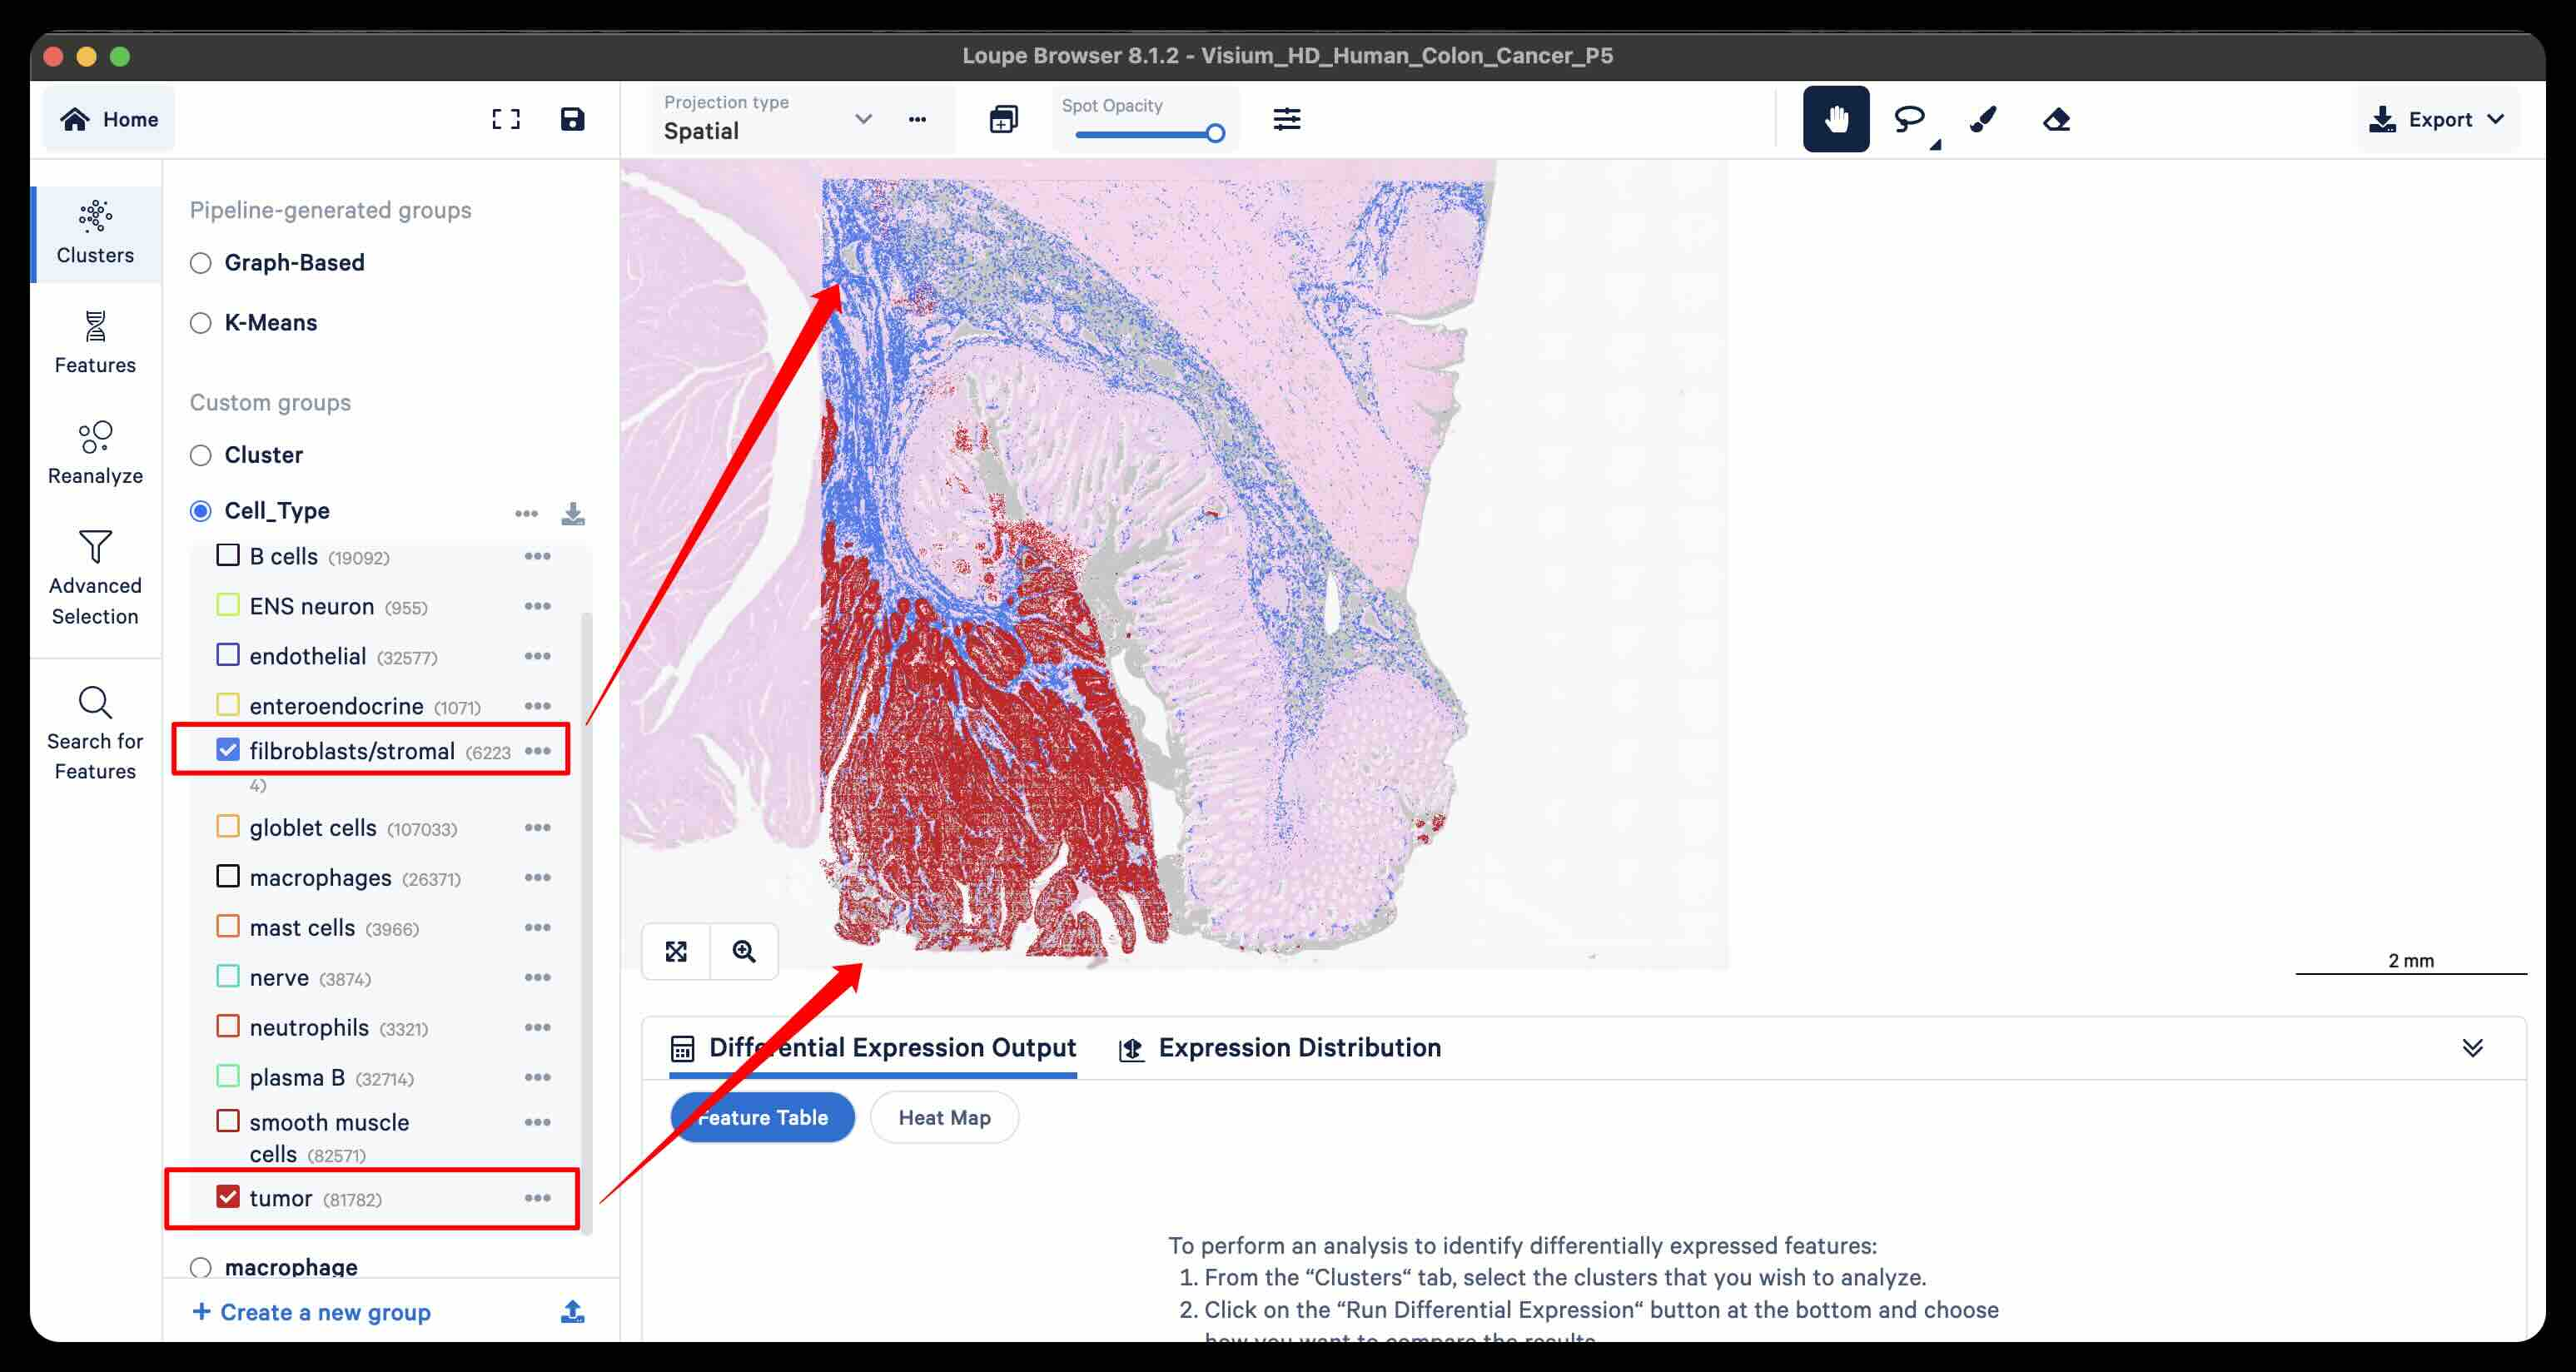

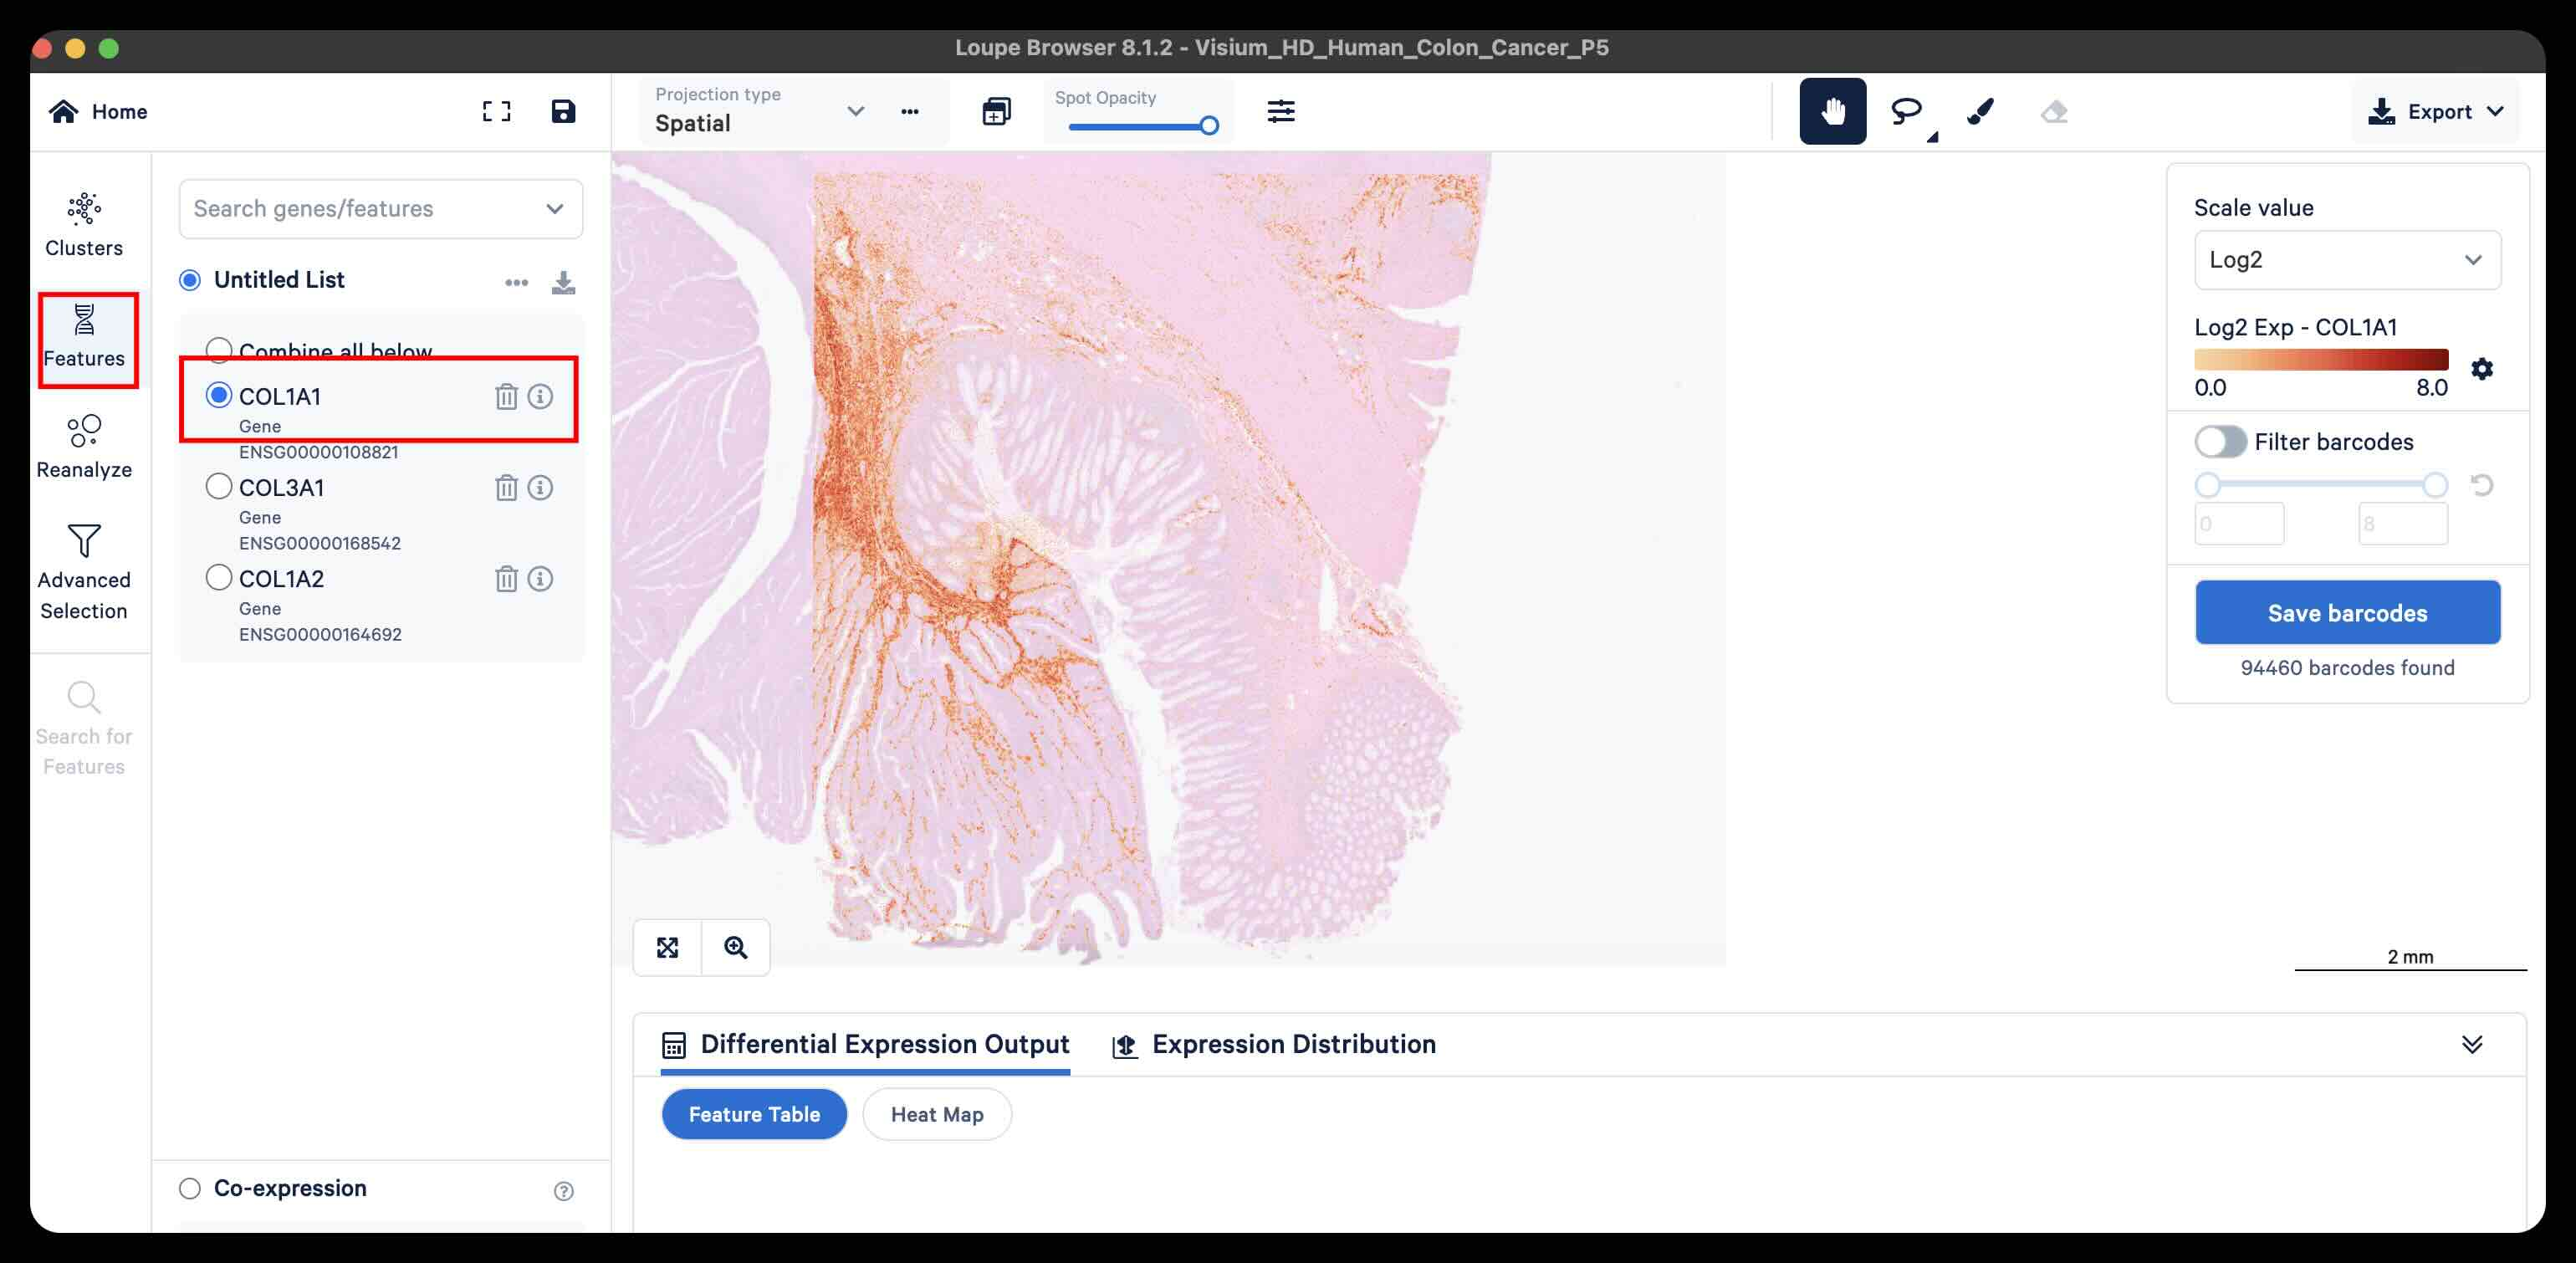

- Normal adjacent tissue

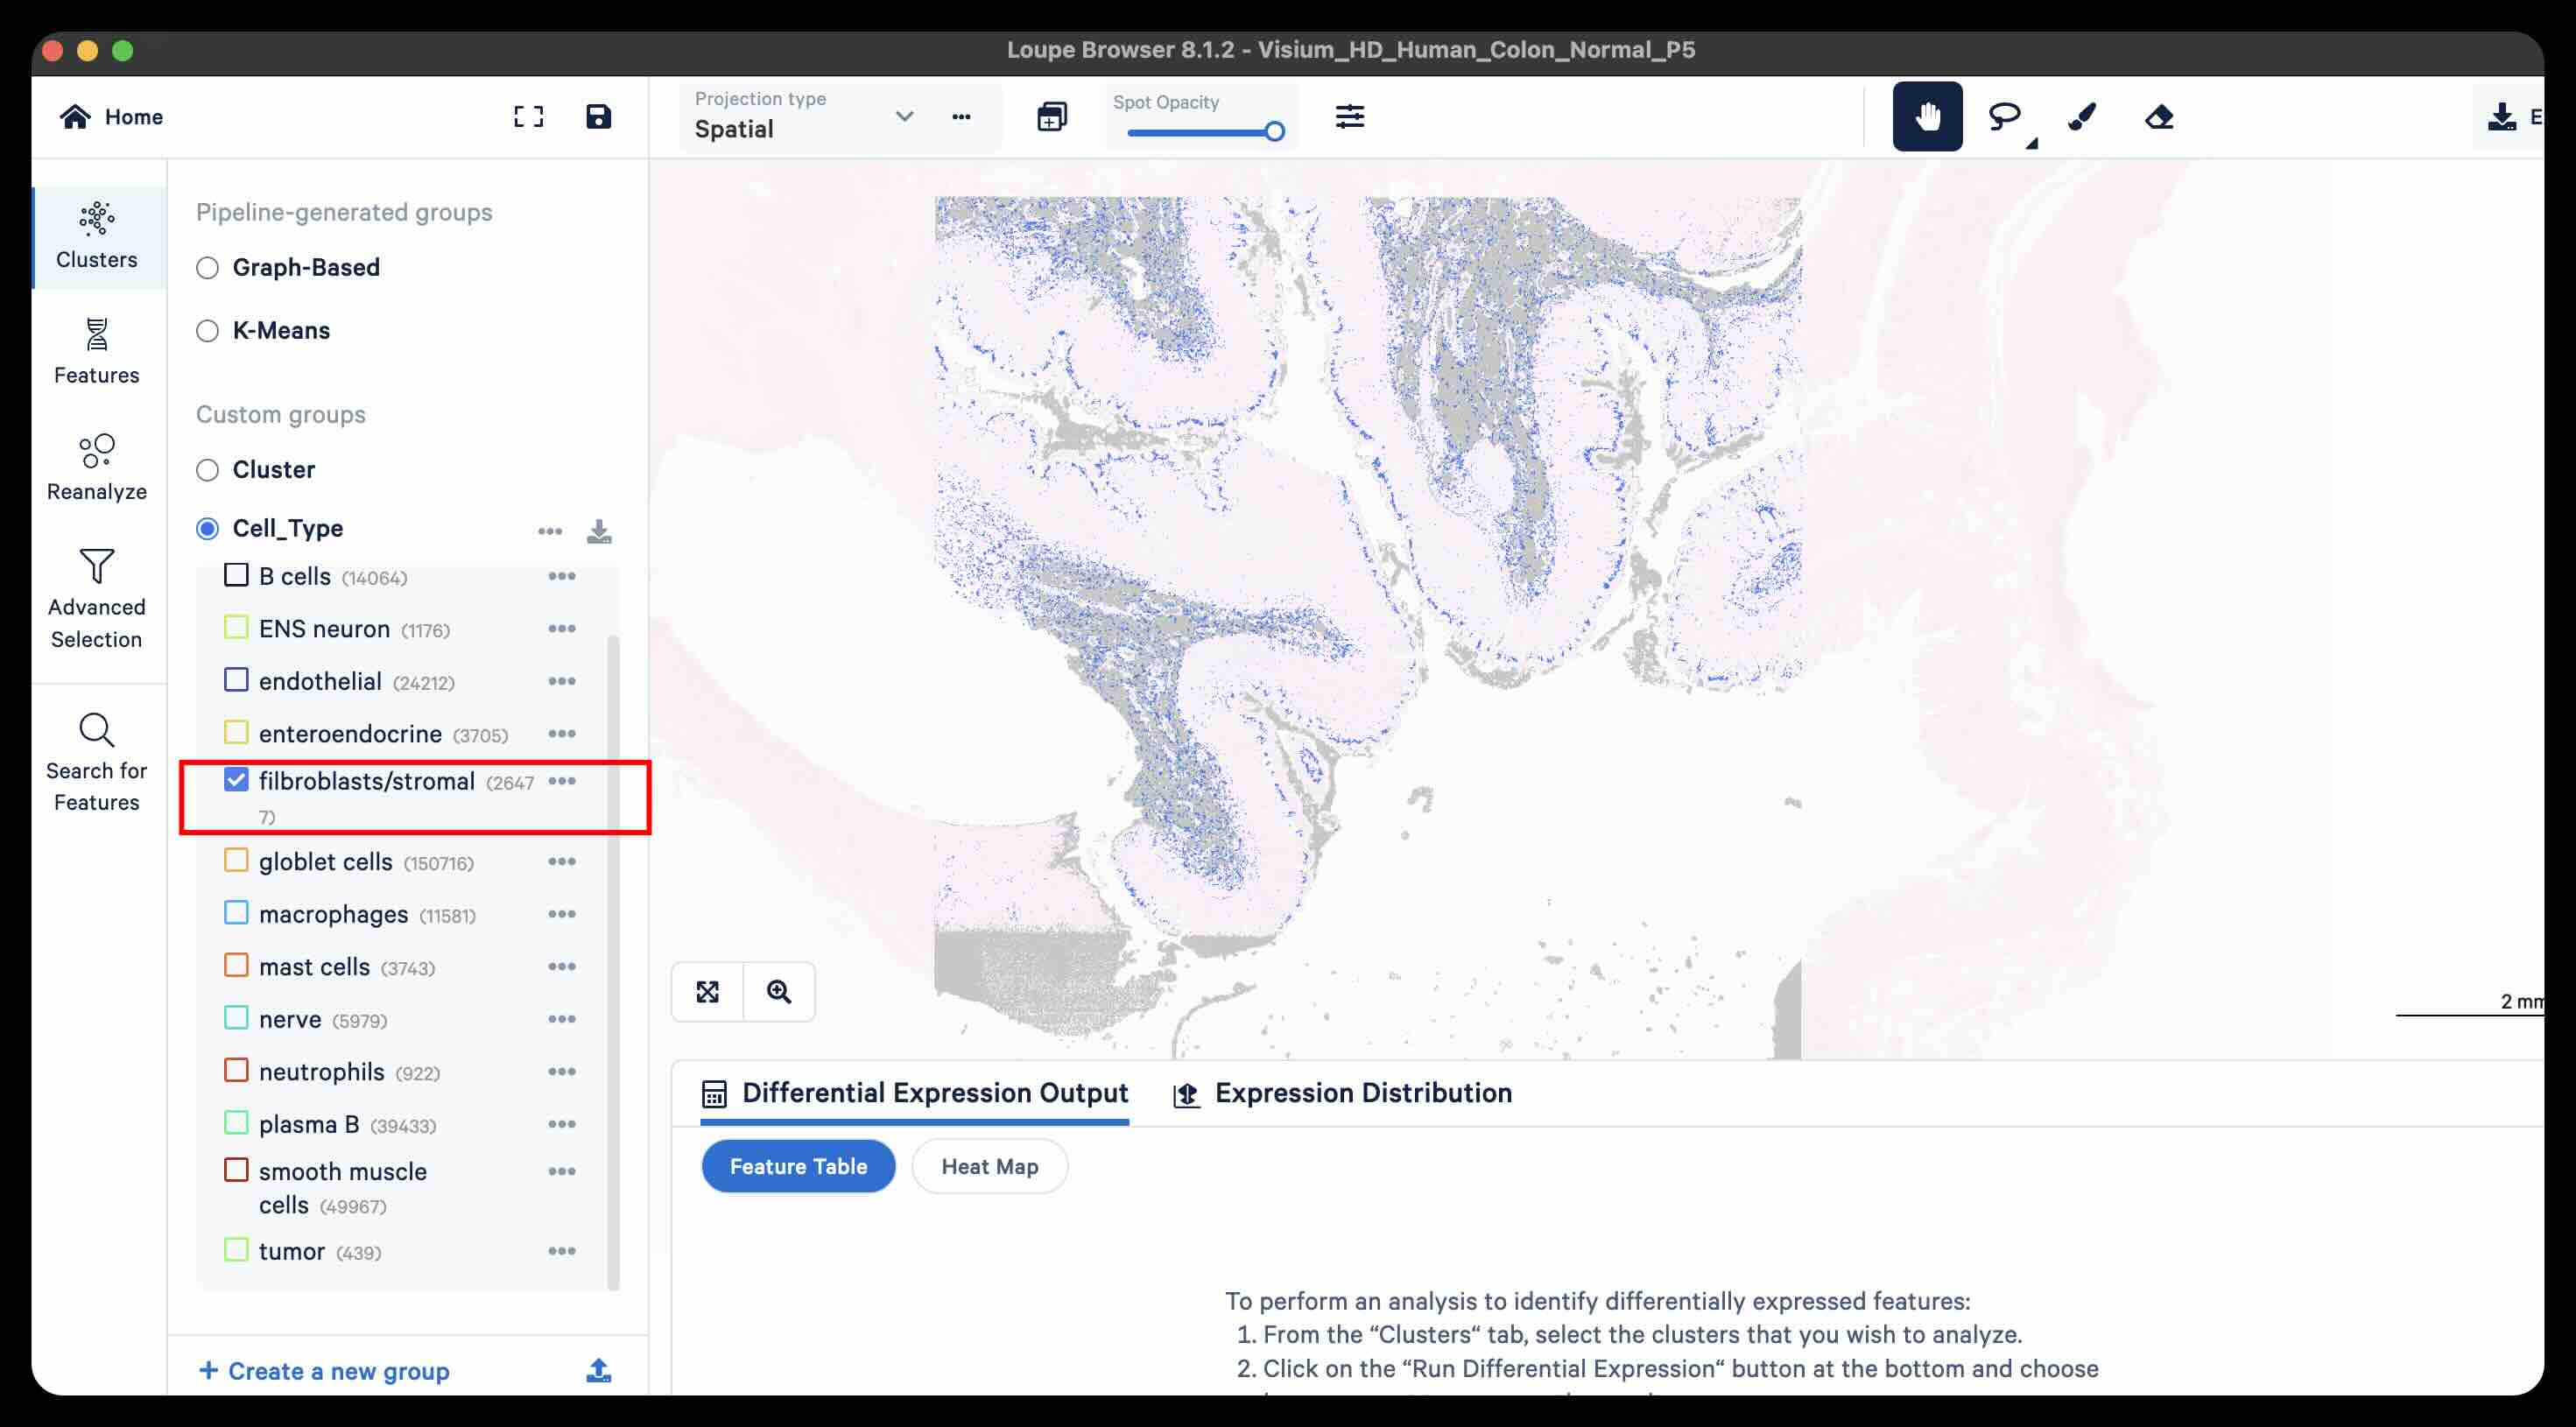

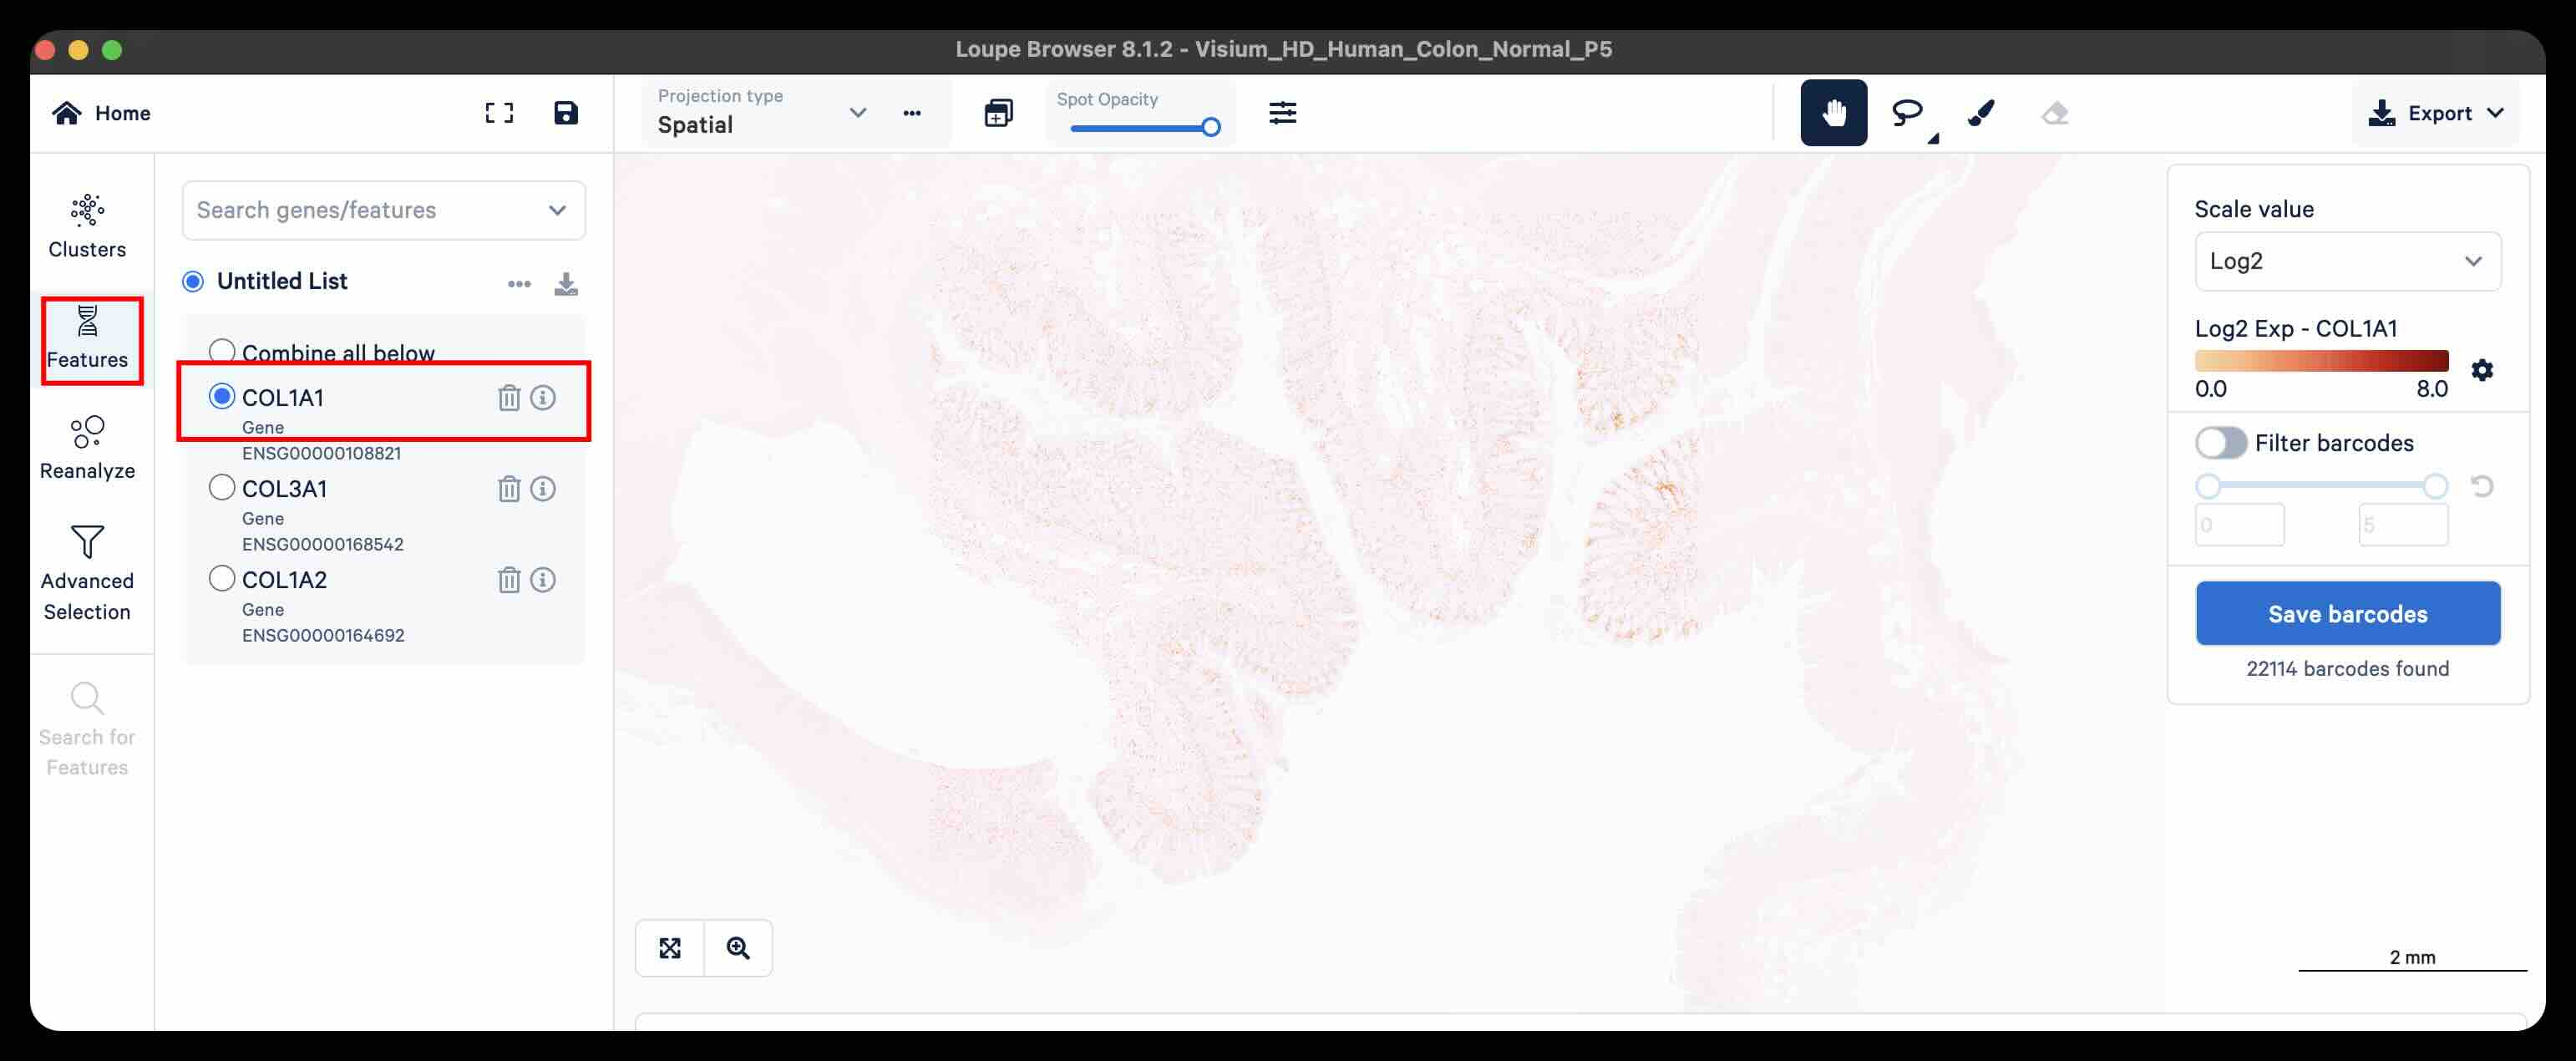